## Hyperparameter tuning with Optuna

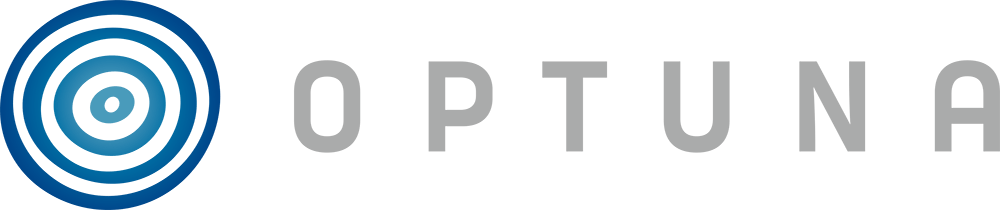

📖**Resource:** Read the Optuna [documentation](https://optuna.readthedocs.io/en/stable/)

### 🔎**Optuna overview:**

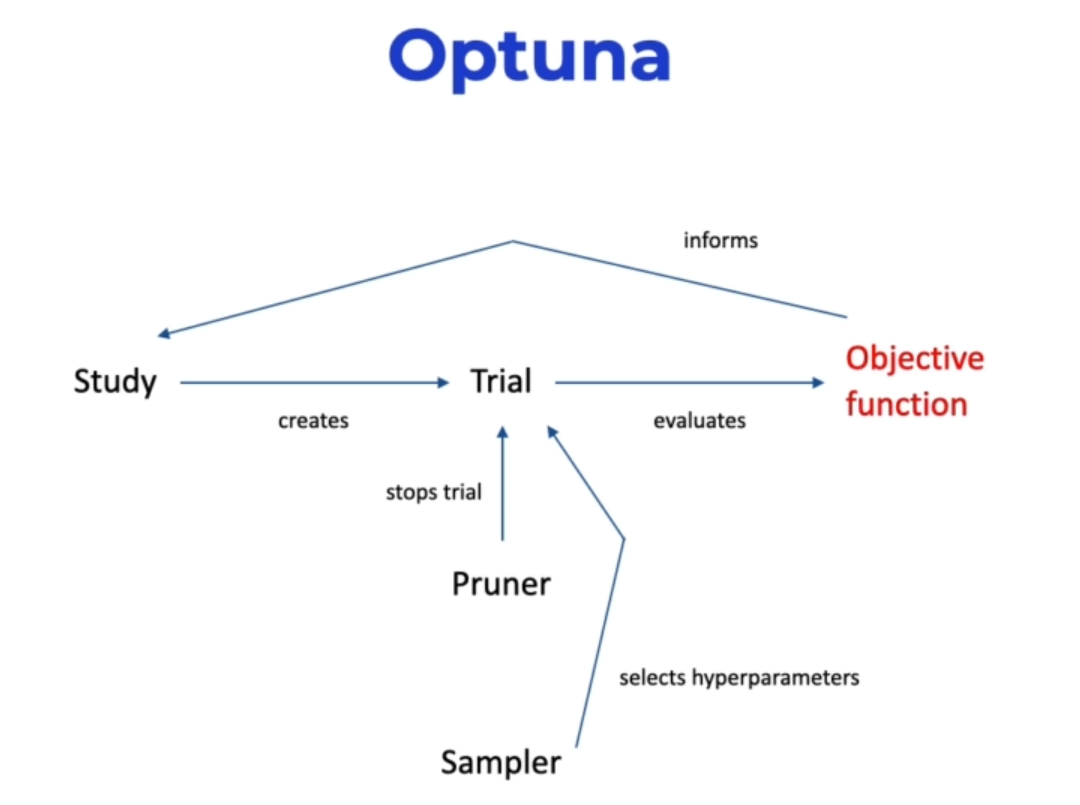

###🔎**Study**

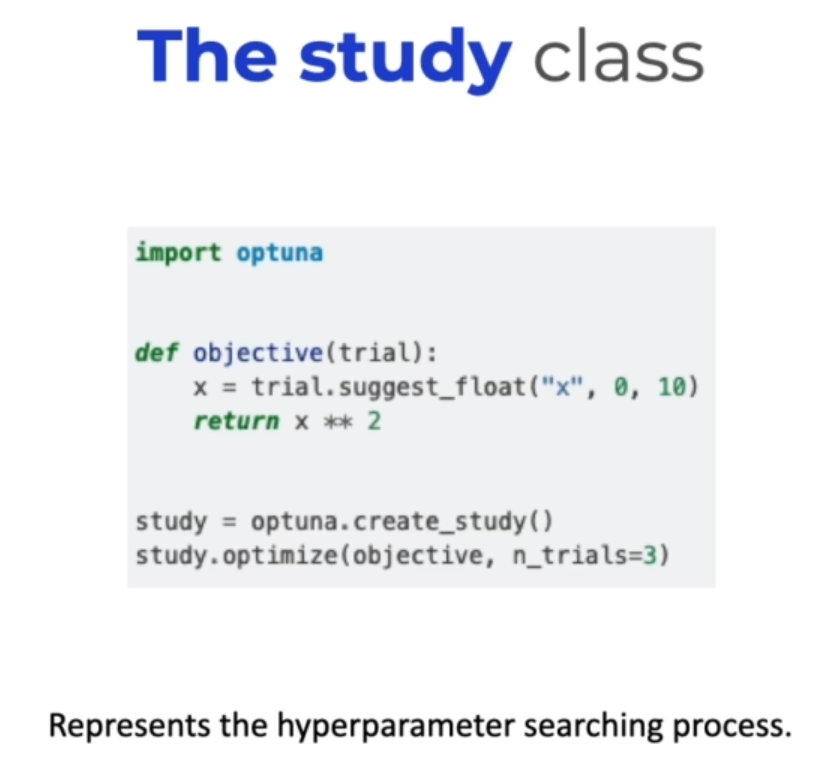

###🔎**Trial**

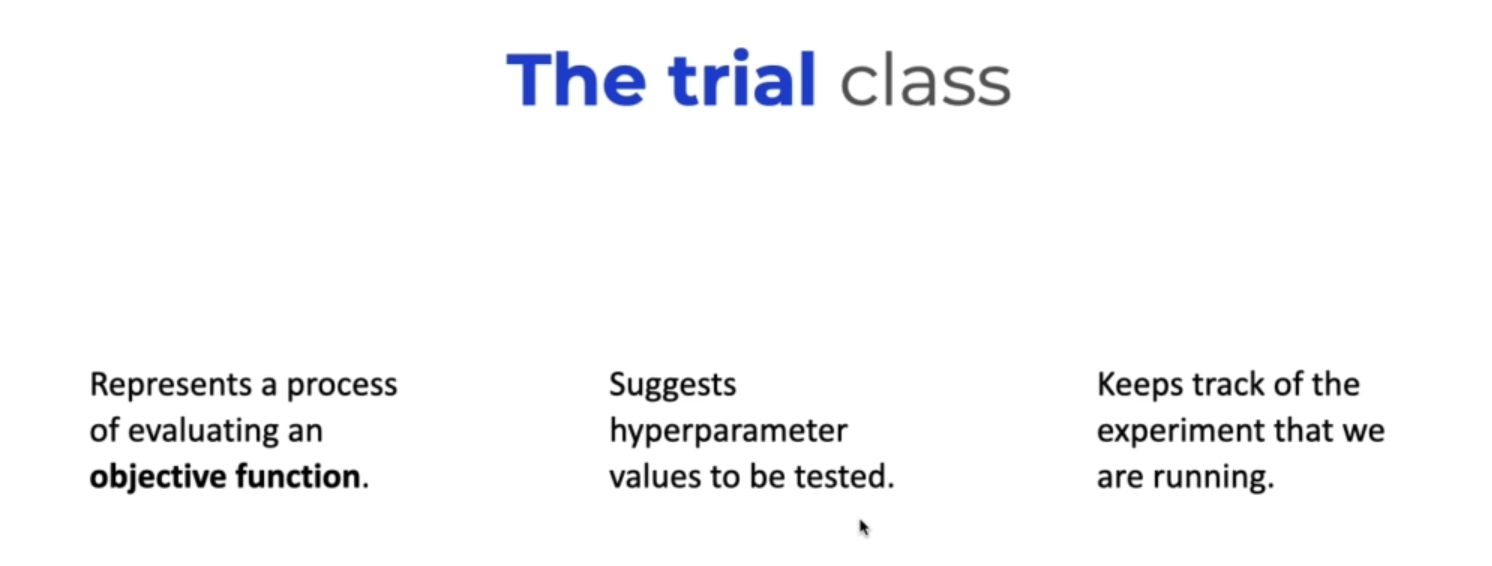

###🔎**Objective function**

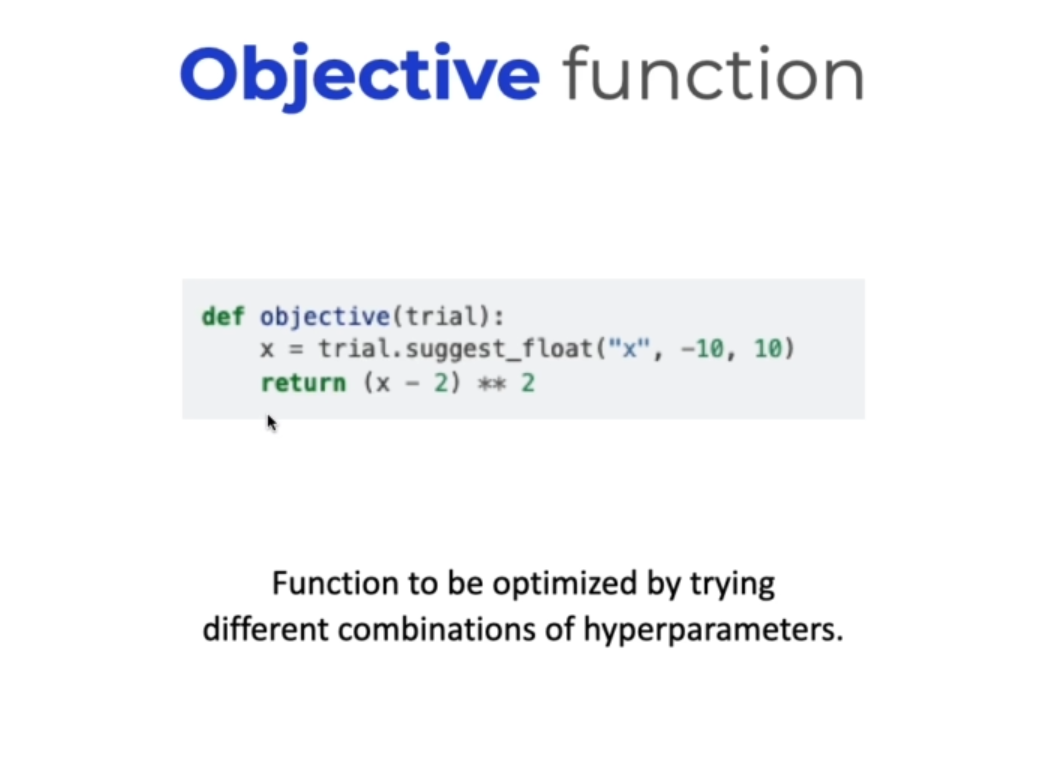

###🔎**Sampler**

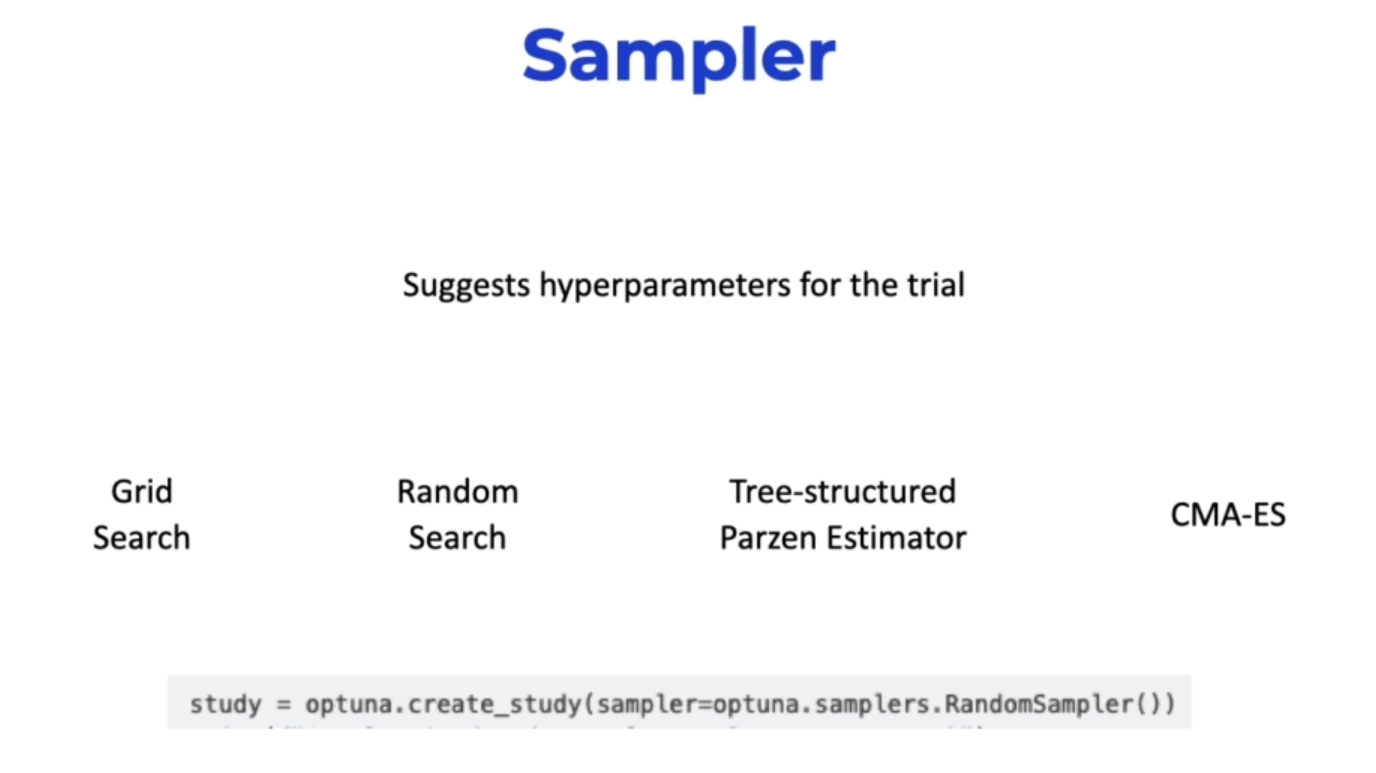

###🔎**Pruner**

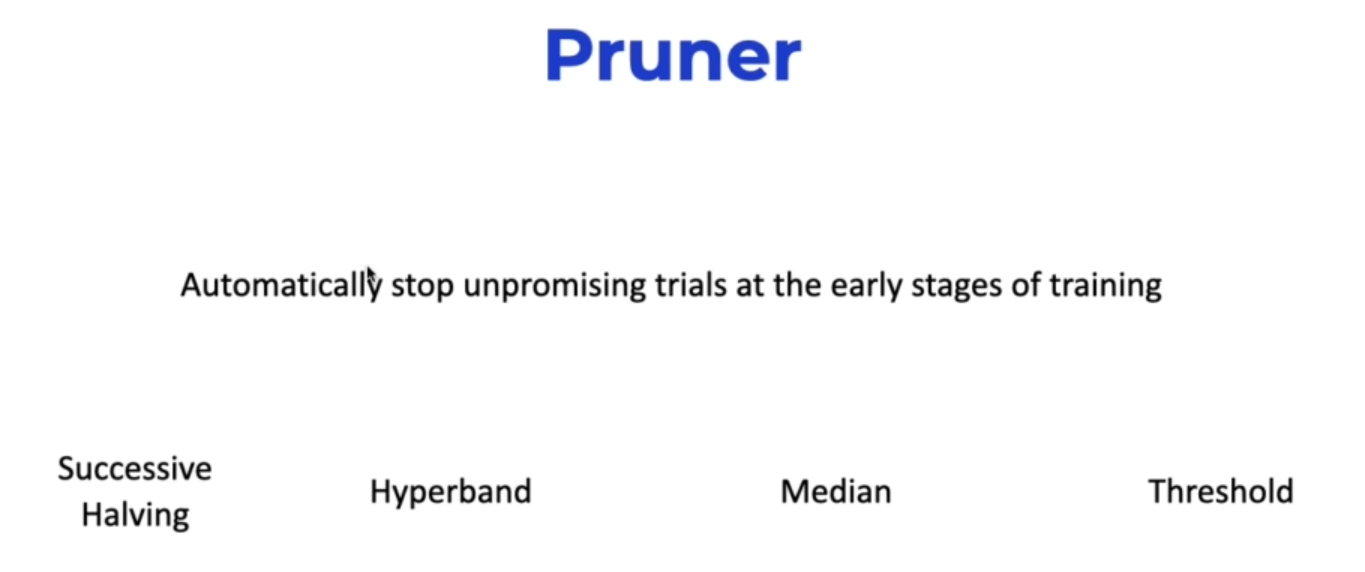

### Installation

In [1]:
!apt-get install -y xvfb

!pip install \
    gym==0.21 \
    gym[box2d] \
    pytorch-lightning==1.5.8 \
    pyvirtualdisplay

###Setup virtual display

In [ ]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

### Import the necessary code libraries

In [ ]:
import copy
import gym
import torch
import random

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from pytorch_lightning.callbacks import EarlyStopping

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [ ]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video")

###Create the Deep Q-Network

In [ ]:
class DQN(nn.Module):

  def __init__(self, hidden_size, obs_size, n_actions): #[q1, q2, q3] 
    super().__init__() #Prepares the NN
    #A list of layers that will be sequential
    self.net = nn.Sequential( 
        nn.Linear(obs_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_actions)
    )

  def forward(self, x):
    return self.net(x.float())

###Create the policy

In [ ]:
def epsilon_greedy(state, env, net, epsilon=0.0):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    state = torch.tensor([state]).to(device)
    q_values = net(state)
    _, action = torch.max(q_values, dim=1)
    action = int(action.item())
  return action

###Create the replay buffer

In [1]:
class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)

  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size)

###Create the dataset

In [ ]:
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=400):
    self.buffer = buffer
    self.sample_size = sample_size

  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

###Create the environment

In [ ]:
def create_environment(name):
  env = gym.make(name)
  env = TimeLimit(env, max_episode_steps=400)#
  env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda x: x % 50 == 0)
  env = RecordEpisodeStatistics(env) #Keeps track of the rewards the agent obtains
  return env

###Create the Deep Q-learning algorithm

In [ ]:
class DeepQLearning(LightningModule):

  #Ctor.
  def __init__(self, env_name, policy=epsilon_greedy, capacity=100_000,
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99,
               loss_fn=F.smooth_l1_loss, optim=AdamW, eps_start=1.0, eps_end=0.15, 
               eps_last_episode=100, samples_per_epoch=10_000, sync_rate=10):
    
    super().__init__()
    self.env = create_environment(env_name)

    obs_size = self.env.observation_space.shape[0]
    n_actions = self.env.action_space.n

    self.q_net = DQN(hidden_size, obs_size, n_actions)

    self.target_q_net = copy.deepcopy(self.q_net)

    self.policy = policy
    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()

    while len(self.buffer) < self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in experience buffer. Filling..")
      self.play_episode(epsilon=self.hparams.eps_start)

  @torch.no_grad()
  def play_episode(self, policy=None, epsilon=0.):
    state = self.env.reset()
    done = False

    while not done:
      if policy:
        action = policy(state, self.env, self.q_net, epsilon=epsilon)
      else:
        action = self.env.action_space.sample()
      next_state, reward, done, info = self.env.step(action)#
      exp = (state, action, reward, done, next_state)#
      self.buffer.append(exp)#
      state = next_state#

  #Forward.
  def forward(self, x):
    return self.q_net(x)

  #Configure the optimizers.
  def configure_optimizers(self):
    q_net_optimizer = self.hparams.optim(self.q_net.parameters(), lr=self.hparams.lr)
    return [q_net_optimizer]

  #Create dataloader.
  def train_dataloader(self):
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size
    )
    return dataloader

  #Training step.
  def training_step(self, batch, batch_idx):
    states, actions, rewards, dones, next_states = batch
    actions = actions.unsqueeze(1)
    rewards = rewards.unsqueeze(1)
    dones = dones.unsqueeze(1)

    state_action_values = self.q_net(states).gather(1, actions)

    next_action_values, _ = self.target_q_net(next_states).max(dim=1, keepdim=True)
    next_action_values[dones] = 0.0 

    expected_state_action_values = rewards + self.hparams.gamma * next_action_values

    loss = self.hparams.loss_fn(state_action_values, expected_state_action_values)
    self.log('episode/Q-Error', loss)
    return loss

  #Training epoch end.
  def training_epoch_end(self, training_step_outputs):

    epsilon = max(
        self.hparams.eps_end, #hparam b4
        self.hparams.eps_start - self.current_epoch / self.hparams.eps_last_episode
    )

    self.play_episode(policy=self.policy, epsilon=epsilon)
    self.log('episode/Return', self.env.return_queue[-1])

    if self.current_epoch % self.hparams.sync_rate == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

###Create the objective function